# Week 5 Assignment:  GANs

**Data Source**: hhttps://www.kaggle.com/competitions/gan-getting-started/data

**Data Description**: 
* 4 Directories:
    * monet_jpg
        * 300 Monet paintings (256x256, .jpg)
    * monet_tfrec
        * 300 Monet paintings (256x256, TFRecord)
    * photo_jpg
        * 7028 photos (256x256, .jpg)
    * photo_tfrec
        * 7028 photos (256x256, TFRecord)
* There is two formats of data input, .jpg and tfrecord format.  
* The objective of the dataset for the competition is to train a GAN that can generate images in the style of Monet.  
* The generator should be trained using a discriminator.
* The CycleGAN is recommended for this competition.

## 1. EDA

## 1.1 Import Libraries

In [1]:
import os
import os
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import os
import numpy as np
from PIL import Image
import torch
import torch
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, SubsetRandomSampler

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We want to train with the GPU if available
print("torch.cuda.is_available()",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available() True


### 1.2 Read in Paths
* I will read in the jpgs to use with PyTorch instead of the TFRecords

In [3]:
path_main = r"/mnt/DATA1/DTSA_5011/Week5_Assignment"
os.chdir(path_main)

In [4]:
GGS_PATH = os.path.join(path_main,"gan-getting-started")

In [5]:
path_photo_jpg = os.path.join(GGS_PATH,"photo_jpg")
path_monet_jpg = os.path.join(GGS_PATH,"monet_jpg")

In [6]:
print("The numner of photos is = ",len(os.listdir(path_photo_jpg)))

The numner of photos is =  7038


In [7]:
print("The numner of monets is = ",len(os.listdir(path_monet_jpg)))

The numner of monets is =  300


### 1.3 Visualize Data
* We will examine a subset of both the monet & photo jpgs to see what we are trying to create
* We can see how the Monet images have the Claude Monet artistic style to them unlike the regular photos.
* We observe our images are indeed 256x256x3 

In [35]:
def show_subset(image_dir,n=5,random_logic=True):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
    if random_logic:
        sample_images = random.sample(image_files, n)
    else:
        sample_images = sorted(list(image_files))[0:n]
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i, image_file in enumerate(sample_images):
        img_path = os.path.join(image_dir, image_file)
        img = plt.imread(img_path)
        if i==0:
            print("img.shape",img.shape)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

img.shape (256, 256, 3)


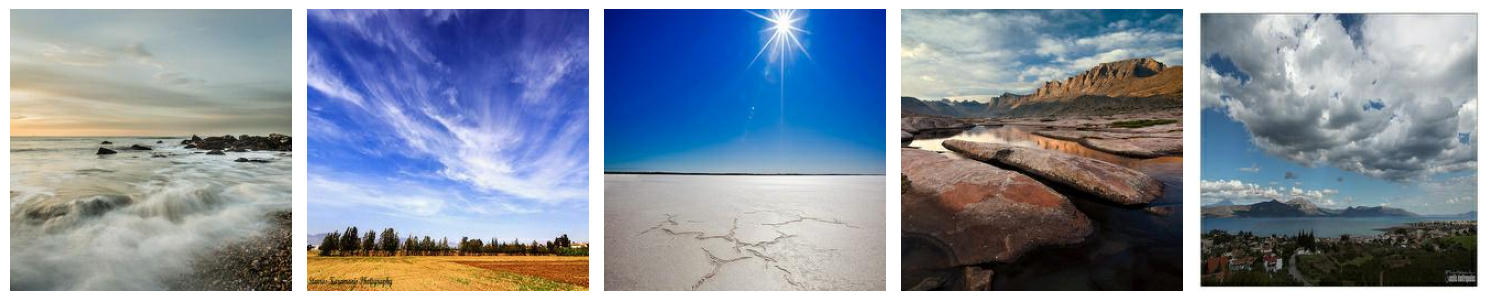

In [9]:
show_subset(path_photo_jpg,n=5,random_logic=True)

img.shape (256, 256, 3)


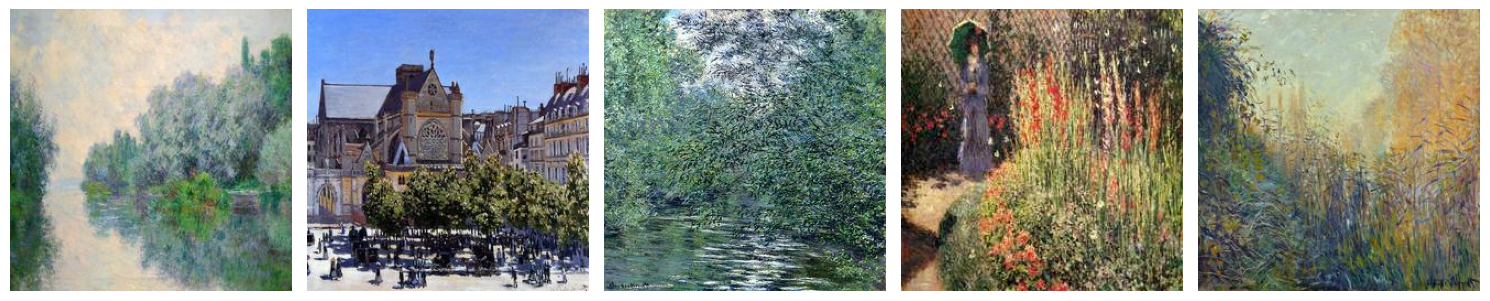

In [10]:
show_subset(path_monet_jpg,n=5,random_logic=True)

## 2.0 Model Building
* I will create a CycleGAN using PyTorch
    * This will require both a Generator and Discriminator
    * This will require a CycleLoss & a Adverserial Loss 
    * I will follow a similar structure to that outlined here except using PyTorch instead of TensorFlow:
        * https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

### 2.1 Output Directories
* We will create an output directory for our GAN weights for restoring and sample images as we train for inspection

In [11]:
OUTPUT_path = "OUTPUT"
if os.path.exists(OUTPUT_path)==False:
  os.makedirs(OUTPUT_path)

In [12]:
# Directory to save model weights
weights_dir = os.path.join(OUTPUT_path,"weights")
os.makedirs(weights_dir, exist_ok=True)

### 2.2 Model Functions

#### 2.2.1 ResidualBlock
* We will create our own ResidualBlock for recusive use within our GAN

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

#### 2.2.2 Generator
* We will inherit the nn.Module
    * We will assign our Generator a forward function to allow it to work with our Discriminator in training
    * We will make our Generator portion of the GAN have a sequential layout with 
        * ReLu activation functions, 
        * Convulational 2d layers, 
        * ResidualBlocks, 
        * InstanceNorm2d, and 
        * Tanh activation function
    * It has upsampling and downsampling portions

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            *[ResidualBlock(256) for _ in range(9)],
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

#### 2.2.3 Discriminator
* We will inherit the nn.Module like we did with our Generator
    * We will make our Discriminator portion of the GAN have a sequential layout with
        * Convolutional 2d layers,
        * LeakyReLU activation functions
        * InstanceNorm2d layers,
* We will also assign a forward function so it works with training the GAN

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

### 2.3 Model Hyperparameters & Optimizations

#### 2.3.1 Hyperparameter Selection
* We will use a small **learning_rate** at first
* We will use a **batch_size** of 1 since that is typical of the CycleGAN
* We will train for a small number of epochs (**num_epochs**) to allow runtime to finish for the Kaggle Competition
* We will set the **image_size** to the image size found in our dataset, 256x256
* We will train on small subsets of data for quicker training using a **subset_fraction**

In [16]:
learning_rate = 0.0002
batch_size = 1  
num_epochs = 2
image_size = 256 
subset_fraction = 0.01

#### 2.3.2 Loss Functions
* The MeanSquaredError (MSE) Loss will be used for the adversarial loss
* The L1 norm loss will be used for our cycle loss

In [17]:
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()

#### 2.3.3 Initialize Generators & Discriminators

In [18]:
G_XtoY = Generator().to(device)#Real to Monet
G_YtoX = Generator().to(device)#Monet to Real
D_X = Discriminator().to(device)#Real discriminator
D_Y = Discriminator().to(device)#Monet discriminator

#### 2.3.4 Optimizers
* We will use the Adam optimizer for our Generators and Discriminators

In [19]:
optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=learning_rate, betas=(0.5, 0.999))

### 2.3.5 DataLoader
* We will use a dataloader that transform the data 

##### 2.3.5.1 ImageDataset
* We will create our own ImageDataset loader to work with PyTorch for loading images from a directory to train with

In [20]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

##### 2.3.5.2 transform
* We will transform our image to be:
    * resized to our input **image_size**
    * to a tensor
    * normalized for input for training

In [21]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

##### 2.3.5.3 create_subset_dataloader
* We will train on subsets of data instead of all of the data to speed up training
* Therefore, we need a helper function to split the incoming datapath into **subset_fractions**

In [22]:
def create_subset_dataloader(dataset, subset_fraction, batch_size):
    num_samples = len(dataset)
    indices = np.arange(num_samples)
    subset_size = int(subset_fraction * num_samples)
    subset_indices = np.random.choice(indices, size=subset_size, replace=False)
    sampler = SubsetRandomSampler(subset_indices)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)


#### 2.3.5.4 Load in the data for training

In [23]:
real_images_dataset = ImageDataset(root_dir=path_photo_jpg, transform=transform)
monet_images_dataset = ImageDataset(root_dir=path_monet_jpg, transform=transform)

## 3.0 Model Training

### 3.1 Training Loop
* We will train for epoch per real_image per monet_image in the subset_fraction from our dataloader.

In [24]:
for epoch in range(num_epochs):
    #Subset from DataLoaders
    real_images_loader = create_subset_dataloader(real_images_dataset, subset_fraction, batch_size)
    monet_images_loader = create_subset_dataloader(monet_images_dataset, subset_fraction, batch_size)
    for real_images in tqdm(real_images_loader):
        for monet_images in monet_images_loader:
            real_images, monet_images = real_images.to(device), monet_images.to(device)
            # Train Discriminator
            discriminator_output_shape = D_X(monet_images).shape
            real_labels = torch.ones(discriminator_output_shape).to(device)
            fake_labels = torch.zeros(discriminator_output_shape).to(device)
            ## Discriminator D_X (Real->Monet)
            fake_monet = G_XtoY(real_images)
            D_X_real_loss = adversarial_loss(D_X(monet_images), real_labels)
            D_X_fake_loss = adversarial_loss(D_X(fake_monet.detach()), fake_labels)
            D_X_loss = (D_X_real_loss + D_X_fake_loss) / 2
            optimizer_D_X.zero_grad()
            D_X_loss.backward()
            optimizer_D_X.step()
            ## Discriminator D_Y (Monet->Real)
            fake_real = G_YtoX(monet_images)
            D_Y_real_loss = adversarial_loss(D_Y(real_images), real_labels)
            D_Y_fake_loss = adversarial_loss(D_Y(fake_real.detach()), fake_labels)
            D_Y_loss = (D_Y_real_loss + D_Y_fake_loss) / 2
            optimizer_D_Y.zero_grad()
            D_Y_loss.backward()
            optimizer_D_Y.step()
            #  Train Generator
            ## Calculate Adversarial loss
            G_XtoY_loss = adversarial_loss(D_X(fake_monet), real_labels)
            G_YtoX_loss = adversarial_loss(D_Y(fake_real), real_labels)
            # Calculate Cycle consistency loss
            reconstructed_real = G_YtoX(fake_monet)
            reconstructed_monet = G_XtoY(fake_real)
            cycle_real_loss = cycle_loss(reconstructed_real, real_images) * 10.0
            cycle_monet_loss = cycle_loss(reconstructed_monet, monet_images) * 10.0
            # Calculate Total generator loss
            G_loss = G_XtoY_loss + G_YtoX_loss + cycle_real_loss + cycle_monet_loss
            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

    if (epoch + 1) % 1 == 0:
        #Save example training images
        print(f"Epoch [{epoch+1}/{num_epochs}] | D_X Loss: {D_X_loss.item()} | D_Y Loss: {D_Y_loss.item()} | G Loss: {G_loss.item()}")
        save_image(fake_monet, os.path.join(OUTPUT_path,f'fake_monet_{epoch+1}.png'))
        save_image(fake_real, os.path.join(OUTPUT_path,f'fake_real_{epoch+1}.png'))
        save_image(monet_images, os.path.join(OUTPUT_path,f'real_monet_{epoch+1}.png'))
        save_image(real_images, os.path.join(OUTPUT_path,f'real_real_{epoch+1}.png'))
        #Save model weights
        torch.save(G_XtoY.state_dict(), os.path.join(weights_dir, f'G_XtoY_epoch_{epoch+1}.pth'))
        torch.save(G_YtoX.state_dict(), os.path.join(weights_dir, f'G_YtoX_epoch_{epoch+1}.pth'))
        torch.save(D_X.state_dict(), os.path.join(weights_dir, f'D_X_epoch_{epoch+1}.pth'))
        torch.save(D_Y.state_dict(), os.path.join(weights_dir, f'D_Y_epoch_{epoch+1}.pth'))


100%|██████████| 70/70 [01:15<00:00,  1.07s/it]


Epoch [1/2] | D_X Loss: 0.26062801480293274 | D_Y Loss: 0.2377670854330063 | G Loss: 6.758698463439941


100%|██████████| 70/70 [01:11<00:00,  1.02s/it]


Epoch [2/2] | D_X Loss: 0.24726499617099762 | D_Y Loss: 0.23848854005336761 | G Loss: 6.2125139236450195


### 3.2 Model Evaluation

#### 3.2.1 Create Output Images

In [25]:
output_images_path = '../images'
if os.path.exists(output_images_path)==False:
  os.makedirs(output_images_path)

#### 3.2.2 Put Generator in Evaluation Mode

In [26]:
# model_path_G_XtoY =  os.path.join(weights_dir, f'G_XtoY_epoch_{epoch+1}.pth'
# G_XtoY = Generator().to(device)
# G_XtoY.load_state_dict(torch.load(model_path_G_XtoY))
G_XtoY.eval()

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d

#### 3.2.3 Helper Function for Prediction and Saving Images
* We create a helper function that can use our generator to inference on an image for prediction and submission

In [33]:

def predict_and_save_images(generator, input_dir, output_dir, transform, device):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_dir_real = os.path.join(os.path.dirname(output_dir),"output_real")
    if not os.path.exists(output_dir_real):
        os.makedirs(output_dir_real)
    real_imgs_dataset = ImageDataset(root_dir=input_dir, transform=transform)
    real_imgs = DataLoader(real_imgs_dataset, batch_size=1)
    for i, real_img in enumerate(tqdm(real_imgs)):
        real_img = real_img.to(device)
        fake_monet = generator(real_img)
        output_image_path = os.path.join(output_dir, f"{i}.jpg")
        save_image(fake_monet, output_image_path)
        output_image_path_real = os.path.join(output_dir_real,f"{i}.jpg")
        save_image(real_img,output_image_path_real)
    return output_dir_real

#### 3.2.4 Convert real images to Monet Style

In [34]:
output_dir_real = predict_and_save_images(G_XtoY, path_photo_jpg, output_images_path, transform,device)

100%|██████████| 7038/7038 [04:02<00:00, 28.99it/s]


#### 3.2.5 Zip images for Kaggle Submission

In [29]:
shutil.make_archive(output_images_path, 'zip', output_images_path)
#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images") # for kaggle

'/mnt/DATA1/DTSA_5011/images.zip'

## 4.0 Results

### 4.1 Show Example Images from Predictions

img.shape (256, 256, 3)


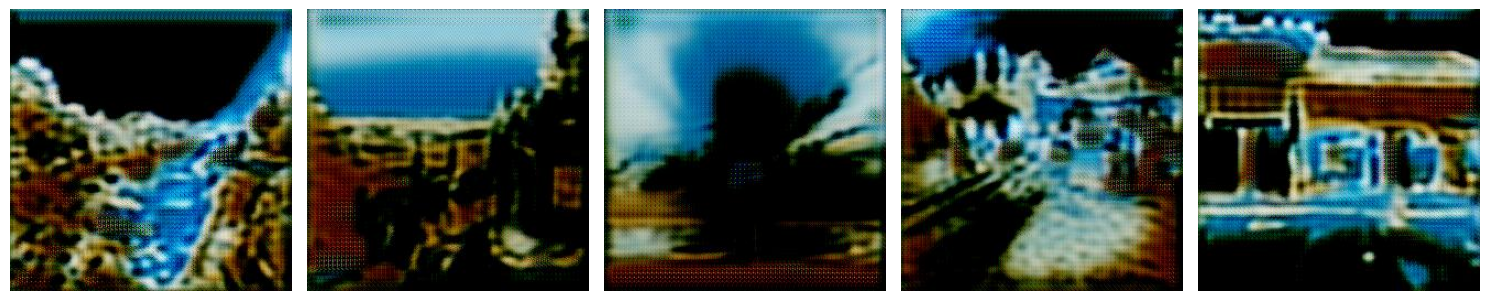

In [36]:
# Predictions
show_subset(output_images_path,n=5,random_logic=False)

img.shape (256, 256, 3)


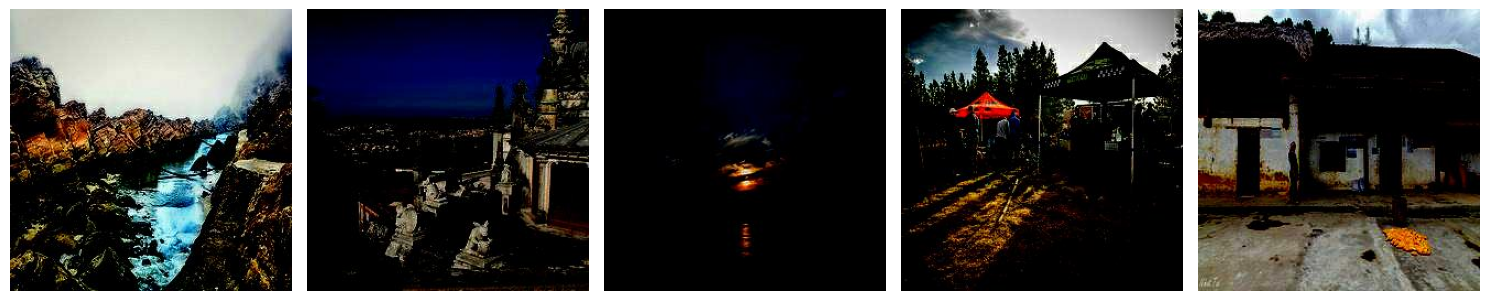

In [37]:
# Originals
show_subset(output_dir_real,n=5,random_logic=False)

### 4.2 Kaggle Results

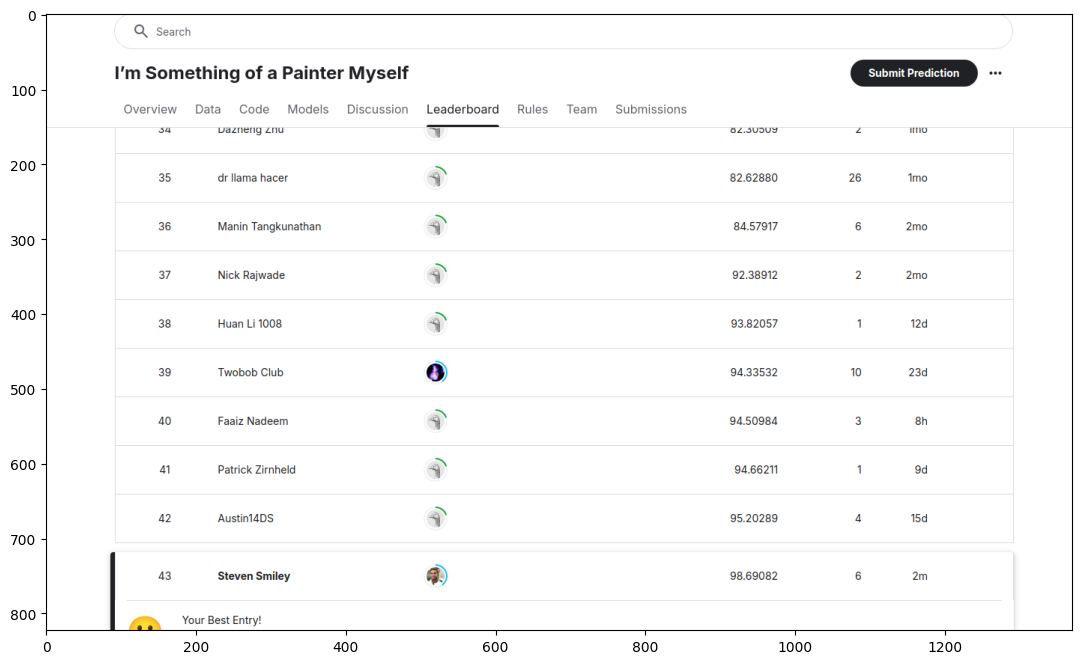

In [38]:
plt.figure(figsize=(20, 8))
plt.imshow(plt.imread("Screenshot from 2024-10-14 20-39-44.png"))
plt.show()

## 5.0 Conclusion
* The model trained well for such little epochs and subset fractions
* If I trained the model for full epochs and longer time on the gpu without subsets, I expect I would have much better results, 
    * However, I thought this small number of epochs and small subset fraction was good enough to know the direction the training would be going
* In the future, I would train for more epochs and for larger fractions